## An Analysis of the Google PageRank Algorithm
By: Dimitriy Leksanov

I first define many of the functions that I will use later in this project. Please skip past them if you prefer.
This notebook is available [on my Github](https://github.com/dleksanov/math212-homeworks/blob/main/final_proj.ipynb) --https://github.com/dleksanov/math212-homeworks/blob/main/final_proj.ipynb for download.

In [1]:
import Pkg; Pkg.add("LightGraphs")
import Pkg; Pkg.add("SimpleWeightedGraphs")
import Pkg; Pkg.add("GLMakie")
import Pkg; Pkg.add("GraphMakie")
import Pkg; Pkg.add("GraphRecipes")
import Pkg; Pkg.add("Plots")
import Pkg; Pkg.add("Graphs")
import Pkg; Pkg.add("Colors")
import Pkg; Pkg.add("StatsBase")
import Pkg; Pkg.add("Distributions")

Pkg.add(url="git://github.com/afternone/GraphPlot.jl.git")

using LightGraphs, SimpleWeightedGraphs, GLMakie
using GraphMakie, GraphRecipes, Plots, Graphs, Colors, GraphPlot, Random, StatsBase, Distributions 

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes

In [2]:
# Defining norm and inner product functions
function supnorm(u) 
    s = 0 
    for entry in u 
        s = max(abs(entry),s) 
    end 
    return s 
end 

function inner_product(u::Array{<:Real,1}, v::Array{<:Real,1}) 
    s = 0 
    n = size(u)[1] 
    for i in 1:n
        s += u[i] * v[i] 
    end 
    return s
end

# The power method for finding eigenvectors and Rayleigh's formula for finding eigenvalues
function power_method(A::Array{<:Real,2}, x0::Array{<:Real,1}, normalize::Bool=true)
    y = A*x0
    x = y / supnorm(y)
    if normalize
        return x
    else
        return y
    end
end

function rayleigh(A::Array{<:Real,2}, x0::Array{<:Real,1})
    lambda = inner_product(x0, A*x0) / inner_product(x0, x0)
    return lambda
end

# Iterating steps of the power method
function power_method_iterate(A::Array{<:Real,2}, x::Array{<:Real,1}, iterations::Int, 
        stochastic_vec::Bool=true, normalize::Bool=true)
    for i in 1:iterations
        x = power_method(A, x, normalize)
    end
    lambda = rayleigh(A, x)
    if stochastic_vec
        tot_x = sum(x)
        x = x / tot_x
    end
    return x, lambda
end 

# Function to check if matrix is indeed column-stochastic
function check_unit_columns(A::Array{<:Real,2})
    n = size(A)[1]
    
    for j in 1:n
        s = 0
        for i in 1:n
            s += A[i, j]
        end
        # println("Column ", j, ": ", s)
    end
end

# Function to fill missing columns
function fill_columns(A::Array{<:Real,2})
    n = size(A)[1]
    
    B = zeros(size(A)[1], size(A)[2])
    
    for j in 1:n
        s = 0
        for i in 1:n
            s += A[i, j]
            B[i, j] += A[i, j]
        end
        if s < 1
            to_add = (1 - s) / n
            for i in 1:n
                B[i, j] += to_add
            end
        end
    end
    
    return B
end

# Using a "damping factor" to randomly teleport between disconnect components
# Mimics the search bar
function search_bar(A::Array{<:Real,2}, damp::Real=0.15, fill_cols::Bool=true)
    if fill_cols
        A = fill_columns(A)
    end
    return (1 - damp)*A + damp*(ones(size(A)[1], size(A)[2]) / size(A)[1])
end

# Perform the PageRank algorithm, for checks for disconnected components or vertices with no out-edges
function page_rank(A::Array{<:Real,2}, x::Array{<:Real,1}=[NaN], iterations::Int=100, page_names=[nothing], 
        damp::Real=NaN, fill_cols::Bool=false, stochastic_vec::Bool=true, normalize::Bool=true)
    # println(A)
    
    if !isnan(damp)
        A = search_bar(A, damp)
    elseif fill_cols
        A = fill_columns(A)
    end
    
    # println(A)
    
    if isnan(x[1])
        x = ones(size(A)[1]) / size(A)[1]
        # println(x)
    end
    
    for i in 1:iterations
        x = power_method(A, x, normalize)
    end
    if stochastic_vec
        x_sum = sum(x)
        x = x / x_sum
    end
    
    lambda = rayleigh(A, x)
    
    println("Largest eigenvalue (should be 1): ", lambda)
    println("Page rank weight eigenvector: ", x)
    if isnothing(page_names[1])
        println("Pages in order from most to least important: ", sortperm(x, rev=true)) 
    else 
        println("Pages in order from most to least important: ", page_names[sortperm(x, rev=true)]) 
    end
    
    return x, lambda
end 

# Split uniform distribution
function random_uniform_split(n::Int, x::Int=1)
    tot = 0
    ret = []
    for i in 2:n
        to_add = rand(Uniform(0, x))
        append!(ret, to_add)
        x -= to_add
        tot += to_add
    end
    append!(ret, (1-tot))
    # println(ret)
    # println(sum(ret))
    return ret
end

# Create a random column-stochastic matrix
# Matrix must be connected
function create_random_adjacency_matrix(replacement::Bool=true, self_edges::Bool=false, 
        random_weights::Bool=false, chaos_column_weight::Real=1., side=nothing)
    
    if isnothing(side)
        side = rand((3:6))
    end
    A = zeros(side, side)
    
    # Creating one "chaos column" to throw matrix out of wack
    chaos_col = rand((1:side))
    
    for j in 1:side
        # num_edges = rand((1:side))
        # weight = 1. / num_edges
        
        total_weight = 1.
        if ((chaos_column_weight != 1.) & (j == chaos_col))
             total_weight = chaos_column_weight
        end
        
        # Need a way to generate edges - with replacement for different weights, w/out for uniform
        if self_edges
            num_edges = rand((1:side))
            weight = total_weight / num_edges
            edges_to_add = sample(1:side, num_edges, replace = replacement)
        else
            num_edges = rand((2:side)) - 1
            weight = total_weight / num_edges
            edges_to_add = sample(filter!(x->x≠j,[x for x in 1:side]), num_edges, replace = replacement)
        end
        if random_weights
            k = 1
            random_weights_pool = sample(random_uniform_split(num_edges), num_edges, replace = replacement)
        end
        for i in edges_to_add
            if !random_weights
                A[i, j] += weight
            else
                if j != chaos_col
                    A[i, j] += random_weights_pool[k]
                    k += 1
                else
                    A[i, j] += (random_weights_pool[k])*chaos_column_weight
                    k += 1
                end
            end
        end
    end
    return A
end

# Create column-stochastic adjacency matrix with disconnected components
function create_segmented_adjacency_matrix(n::Int, chaos_weights::Array{<:Real,1}=[-1], replacement::Bool=true, self_edges::Bool=false, 
        random_weights::Bool=false)
    matrix_array = []
    matrix_size_array = []
    for m in 1:n
        segment_size = rand((2, 4))
        append!(matrix_size_array, segment_size)
    end
    
    # Building the big matrix
    full_size = sum(matrix_size_array)
    full_matrix = zeros(full_size, full_size)
    
    curr = 0
    for k in 1:n
        curr_size = matrix_size_array[k]
        if chaos_weights[1] != -1
            curr_weight = chaos_weights[k]
        else
            curr_weight = 1.
        end
        mat = create_random_adjacency_matrix(replacement, self_edges, random_weights, curr_weight, curr_size)
        for i in 1:curr_size
            for j in 1:curr_size
                full_matrix[curr+i, curr+j] = mat[i, j]
            end
        end
        curr += curr_size
    end
    
    return full_matrix
end

# Create a colorful weighted graph to represent the adjacency matrix
function create_weighted_graph(A::Array{<:Real,2}, curve::Bool=false, 
        create_rank_labels::Bool=true, stochastic_vec::Bool=true, 
        normalize::Bool=true, really_big::Bool=false)
    A_graph = SimpleWeightedDiGraph(transpose(A))
    A_adjacency = vec(A)
    A_edges = zeros(Graphs.ne(A_graph))
    # println(A_edges)
    i = 1
    for x in 1:(size(A)[1]*size(A)[2])
        if A_adjacency[x] != 0
            A_edges[i] += A_adjacency[x]
            i += 1
        end
    end
    A_edges = [round(x, digits = 3) for x in A_edges]
    # println(A_edges)
    nodelabels = [x for x in 1:size(A)[1]]
    
    # Sizing and coloring by page rank
    ranking_output = page_rank(A, [NaN], 100, [nothing], NaN, false, stochastic_vec, normalize)
    ranks = [round(x, digits = 3) for x in ranking_output[1]]
    #max_rank = maximum(ranks)
    max_rank = 1
    
    color_range = range(colorant"yellow", stop=colorant"red", length=100)
    colors = [color_range[trunc(Int, (x/max_rank)*99)+1] for x in ranking_output[1]]
    
    full_nodelabels = []
    for j in 1:size(A)[1]
        full_label = string(nodelabels[j], ": ", ranks[j])
        # println(full_label)
        append!(full_nodelabels, " ")
        full_nodelabels[j] = full_label
    end
    
    # println(ranks)
    # println(full_nodelabels)
    
    #gplot(A_graph, nodelabel=nodelabels, edgelabel=A_edges, linetype="curve", edgelabeldistx=0, edgelabeldisty=0)
    #gplot(A_graph, nodelabel=nodelabels, edgelabel=A_edges, edgelabeldistx=0, edgelabeldisty=0)
    layout=(args...)->spring_layout(args...; C=12)
    if really_big
        gplot(A_graph, nodelabel=full_nodelabels, layout = layout, nodesize = ranks*3, nodefillc = colors)
    else
        if curve
            if create_rank_labels
                gplot(A_graph, nodelabel=full_nodelabels, edgelabel=A_edges, linetype="curve", 
                    edgelabeldistx=0, edgelabeldisty=0, layout = layout, nodesize = ranks*1.5, nodefillc = colors)
            else
                gplot(A_graph, nodelabel=nodelabels, edgelabel=A_edges, linetype="curve", 
                    edgelabeldistx=0, edgelabeldisty=0, layout = layout)
            end
        else
            if create_rank_labels
                gplot(A_graph, nodelabel=full_nodelabels, edgelabel=A_edges, edgelabeldistx=0, edgelabeldisty=0, 
                    layout = layout, nodesize = ranks, nodefillc = colors)
            else
                gplot(A_graph, nodelabel=nodelabels, edgelabel=A_edges, edgelabeldistx=0, edgelabeldisty=0, 
                    layout = layout)
            end
        end
    end
end

create_weighted_graph (generic function with 6 methods)

## Google PageRank: An Introduction
In programming a search engine, one of the preeminent tasks is to figure out a way to accurately, robustly, and objectively rank web pages in order of importance. This is a difficult task to tackle, as the problem itself is difficult to describe and visualize -- for instance, what even is an *important* web page, and how do we quantify that?

Suppose we have four web pages, titled **1**, **2**, **3**, and **4**. One idea for determining importance could simply be to survey a bunch of people, and ask them which ones they believe are important. However, this is a bit problematic, as it is completely subjective.

If we are looking for objectivity, it could be useful to observe the structure of the various pages, and determine which pages are most interconnected with the others. For instance, we could say that the page that has the most links leading to it is the most important.

However, upon closer examination, this approach becomes problematic as well. For example, suppose I am a young entrepreneur who decided to start a small business -- **Gold Bird LLC**.

In this fictitious scenario, I am very savvy, and I figure out that Google's fictitious PageRank algorithm relies exclusively on the number of links leading into a page to determine importance. So, with the hope of getting **Gold Bird LLC** to the top of every Google search, I decide to game the system: I write a script that auto-generates millions upon millions of webpages that feature nothing except a link to the website for **Gold Bird LLC**. 

So, we can already see why this approach is problematic: my company's page will register as being extremely important because it has millions and millions of links leading to it, but, of course, these links are on phony webpages that nobody will ever visit, so my page is still certainly not *imporant* by any reasonable interpretation of the word.

## A better way!
Instead of the aforementioned approaches, a more robust way to address the problem of ranking webpages would be through the purview of somebody "surfing" the internet: broadly, the importance of a page is determined by how likely someone would be to arrive on that page, after a significant or indefinite amount of surfing.

Let's construct an extremely simple scenario using our four web pages, **1**, **2**, **3**, and **4**. Suppose that they are linked as follows:
- **1** has links leading to **2** and **3**
- **2** has links leading to **1**, **3**, and **4**
- **3** has links leading to **1** and **4**
- **4** has links leading to **1** and **2**

This network of pages appears as follows:

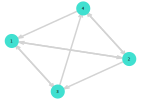

In [3]:
A = [
 0.0  0.333333  0.5  0.5;
 0.5  0.0       0.0  0.5;
 0.5  0.333333  0.0  0.0;
 0.0  0.333333  0.5  0.0
]
gplot(SimpleWeightedDiGraph(transpose(A)), nodelabel=["1", "2", "3", "4"])

Now, we might immediately start to get a hunch that **1** is the most important page, as it has the most links from other pages leading to it. In fact, every other page has a link leading to **1**. However, we are far from certain.

The next step is to examine just how likely a person would be to get to a particular page given that they are on a different page. For simplicity, suppose that there is just one link per destination on each of the four webpages, and that the links are of equal prominence. In other words, a person who has landed on a particular page is equally likely to click on any of the links and travel to one of the listed web pages. So, a surfer on **1** would have a 50% chance of traveling to either **2** or **3**, a surfer on **2** would have an equal, 33.333% chance of traveling to any of the other pages, and so on.

We can represent these probabilities as follows:

Largest eigenvalue (should be 1): 0.9999997457626641
Page rank weight eigenvector: [0.30508473568378003, 0.25423733575489027, 0.23728812200857485, 0.20338980655275482]
Pages in order from most to least important: [1, 2, 3, 4]


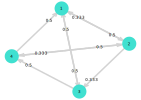

In [4]:
create_weighted_graph(A, false, false)

## The Adjacency Matrix
To examine just how likely a surfer would be to land on a particular page, we can start by creating an adjacency matrix of the relationships between the four web pages. In particular, let the **ith** row entry of the **jth** column represent the probability of traveling to web page **i** from web page **j**. So, our matrix appears as follows:
$$
A = \left(\begin{array}{cc} 
 0.0 & 0.333333 & 0.5 & 0.5\\
 0.5 & 0.0      & 0.0 & 0.5\\
 0.5 & 0.333333 & 0.0 & 0.0\\
 0.0 & 0.333333 & 0.5 & 0.0
\end{array}\right)
$$

For simplicity, let's say that our surfer simply opens up their computer and clicks on *I'm Feeling Lucky* -- that is, they begin on a random page out of the four, each with equal probability. Let $v_{0}$ be the vector of the probabilities that the surfer is on a particular page. So, at the start, this vector is:

$$
v_{0} = \left(\begin{array}{cc} 
 0.25\\
 0.25\\
 0.25\\
 0.25
\end{array}\right)
$$

## The Markov Chain
After our surfer lands on one of the four pages with equal probability, they are bound to click one of the links on that page. However, how would we know how likely they are to end up on a particular page after this first click?

We can determine the probability that the surfer lands on page **i** after this first click by summing the probabilities of the surfer traveling to a particular page **i**, given that they are on page **j**. However, this needs to be a weighted sum, weighted by the probability that the surfer is on page **j** when they click a link (of course, in this first iteration, all of the weights are equal at 0.25).

So, the probability of ending up on **1** is $0.25*0 + 0.25*0.33333 + 0.25*0.5 + 0.25*0.5 = 0.333333$,
the probability of ending up on **2** is $0.25*0.5 + 0.25*0 + 0.25*0 + 0.25*0.25 = 0.25$, and so forth.

Notice that the probabilities of ending up on a particular page after the first click, $v_{1}$, are precisely the vector that you get when you multiply the matrix A by the initial probability vector $v_{0}$:

$$v_{1} = Av_{0} = \left(\begin{array}{cc} 
 0.0 & 0.333333 & 0.5 & 0.5\\
 0.5 & 0.0      & 0.0 & 0.5\\
 0.5 & 0.333333 & 0.0 & 0.0\\
 0.0 & 0.333333 & 0.5 & 0.0
\end{array}\right)\left(\begin{array}{cc} 
 0.25\\
 0.25\\
 0.25\\
 0.25
\end{array}\right) = \left(\begin{array}{cc} 
 0.333333\\
 0.25\\
 0.208333\\
 0.208333
\end{array}\right)$$

Also notice that, as would be expected in a vector of probabilities, just as in $v_{0}$, all of the elements of $v_{1}$ add up to 1. This makes sense, simply given what we know about the matrix A, the vector $v_{0}$, and the mechanics of matrix multiplication. 

Matrix multiplication is essentially a weighted summation of the columns of matrix A, with the elements of $v_{0}$ serving as the weights. Since we have defined the elements of each column in A, as well as the elements of $v_{0}$, to add up to 1, by multiplying A and $v_{0}$, we take a weighted summation of vectors with elements adding up to 1, where the weights all add up to 1. So, the resulting vector, $v_{1}$ also has elements that add up to 1.

Now, what about the probabilities of where the surfer ends up after they click on a link for the second time? Or the third time? Or any subsequent time after that? Let's examine what happens after the surfer clicks on a second link. After they have clicked on the first link, they are at each of the web pages with probability 

$$v_{1} = \left(\begin{array}{cc} 
 0.333333\\
 0.25\\
 0.208333\\
 0.208333
\end{array}\right)$$

So, to find $v_{2}$, the probabilities of being at each page after clicking another link, we must simply repeat the process from before, of taking weighted sums of probabilities that the surfer will travel to page **i** given that they are currently on page **j**. In other words, we can multiply by A again to get $v_{2}$:

$$v_{2} = A^{2}v_{0} = Av_{1} = \left(\begin{array}{cc} 
 0.0 & 0.333333 & 0.5 & 0.5\\
 0.5 & 0.0      & 0.0 & 0.5\\
 0.5 & 0.333333 & 0.0 & 0.0\\
 0.0 & 0.333333 & 0.5 & 0.0
\end{array}\right)\left(\begin{array}{cc} 
 0.333333\\
 0.25\\
 0.208333\\
 0.208333
\end{array}\right) =
\left(\begin{array}{cc} 
 0.291666\\
 0.270833\\
 0.25\\
 0.1875
\end{array}\right)$$

Once again, notice that the entries of $v_{2}$ add up to 1, as expected.

Then, for any subsequent $v_{n}$, we have that $v_{n} = A^{n}v_{0}$:

$$
v_{3} = A^{3}v_{0} \approx \left(\begin{array}{cc} 
 0.3090275\\
 0.2395831\\
 0.2361109\\
 0.2152776
\end{array}\right)
$$

$$
v_{4} = A^{4}v_{0} \approx \left(\begin{array}{cc} 
 0.3055552\\
 0.2621526\\
 0.2343748\\
 0.1979164
\end{array}\right)
$$

and so on.

The process for finding any $v_{n}$ is a **Markov chain**, or "a stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event," as defined on [Wikipedia](https://en.wikipedia.org/wiki/Markov_chain). In this case, each "event" is the surfer choosing to click on yet another link, and the "state attained" by that event is the probability of the surfer ending up on a particular page following that click.

## Convergence??
Now, seeing the first few iterations, you may be starting to get the sense that the probability vectors $v_{n}$ may be converging to... something. Now, it's hard to tell what exactly the vectors are converging to, but each of the components appears to be getting closer and closer to a particular value.

To figure out what convergence, if any, is happening, we first have to think of what "convergence" would even entail here. In this case, since the components of the various vectors $v_{n}$ seem to be getting closer and closer to some value, this suggests that the vectors $v_{n}$ are converging to some *fixed point* of the linear system $Av$ -- that is, some vector v for which $Av = v$.

Of course, this is equivalent to saying that it appears that the vectors $v_{n}$ are converging to an eigenvector $v$ of A, corresponding to the eigenvalue $\lambda = 1$. This eigenvector $v$, in turn, would provide a comprehensive ranking of how important the four pages are, as it would effectively represent the probability that the surfer ends up on a particular page after an indefinite or infinite amount of clicking.

Now, do we even know that A has 1 as one of its eigenvalues, or that the $v_{n}$ are convering to a corresponding eigenvector?

To determine this, we can first look at the transpose of A:

$$
A^{T} = \left(\begin{array}{cc} 
 0.0      & 0.5      & 0.5        & 0.0\\
 0.333333 & 0.0      & 0.333333   & 0.333333\\
 0.5      & 0.0      & 0.0        & 0.5\\
 0.5      & 0.5      & 0.0        & 0.0
\end{array}\right)
$$

Here, we can almost immediately see that 1 is an eigenvector of $A^{T}$, with 
$$
\bar{v} = \left(\begin{array}{cc} 
 1\\
 1\\
 1\\
 1
\end{array}\right)
$$ as the corresponding eigenvector:

$$
A^{T}\bar{v} = \left(\begin{array}{cc} 
 0.0      & 0.5      & 0.5        & 0.0\\
 0.333333 & 0.0      & 0.333333   & 0.333333\\
 0.5      & 0.0      & 0.0        & 0.5\\
 0.5      & 0.5      & 0.0        & 0.0
\end{array}\right)\left(\begin{array}{cc} 
 1\\
 1\\
 1\\
 1
\end{array}\right) = 
\left(\begin{array}{cc} 
 0 + 0.5 + 0.5 + 0\\
 0.333333 + 0 + 0.333333 + 0.333333\\
 0.5 + 0 + 0 + 0.5\\
 0.5 + 0.5 + 0 + 0
\end{array}\right) = 
\left(\begin{array}{cc} 
 1\\
 1\\
 1\\
 1
\end{array}\right)
$$

**Prop. 1:** A matrix A has the same eigenvalues as its transpose, $A^{T}$.

To show that this is true, we can use the fact that the eigenvalues of A are the roots of its characteristic polynomial, $det(A - \tilde{\lambda}I)$.

Now, because a matrix has the same determinant as its transpose, we have that $det(A - \tilde{\lambda}I) = det((A - \tilde{\lambda}I)^{T})$, which by distributivity of the transpose is equal to $det(A^{T} - \tilde{\lambda}I^{T})$, and since $\tilde{\lambda}I$ is a diagonal matrix, it is equal to its transpose. So, we have:

$$det(A - \tilde{\lambda}I) = det(A^{T} - \tilde{\lambda}I)$$.

So, A and $A^{T}$ have the same characteristic polynomial, and thus the same eigenvalues.

Thus, because $A^{T}$ has 1 as an eigenvalue, A must as well.

In fact, we can actually show something much stronger here. Let us define a *column-stochastic* matrix to be any square matrix comprised of non-negative entries, for which the entries of each column sum to 1. Notice that A is a column-stochastic matrix. Now:

**Prop. 2:** Any column-stochastic matrix has 1 as an eigenvalue.

Let B be a column-stochastic matrix, which appears as follows:

$$
B = \left(\begin{array}{cc} 
 b_{1,1}      & b_{1,2}      & ...        & b_{1,n}\\
 b_{2,1} & b_{2,2}      & ...   & b_{2,n}\\
 ...      & ...      & ...        & ...\\
 b_{n,1}      & b_{n,2}      & ...        & b_{n,n}
\end{array}\right)
$$

Then, its transpose, for which the rows sum to 1, takes the following form:

$$
B = \left(\begin{array}{cc} 
 b_{1,1}      & b_{2,1}      & ...        & b_{n,1}\\
 b_{1,2} & b_{2,2}      & ...   & b_{n,2}\\
 ...      & ...      & ...        & ...\\
 b_{1,n}      & b_{2,n}      & ...        & b_{n,n}
\end{array}\right)
$$

Then, if we choose the vector
$$v = \left(\begin{array}{cc} 
 1\\
 1\\
 ...\\
 1
\end{array}\right)$$

we see that

$$
Bv = \left(\begin{array}{cc} 
 b_{1,1}      & b_{2,1}      & ...        & b_{n,1}\\
 b_{1,2} & b_{2,2}      & ...   & b_{n,2}\\
 ...      & ...      & ...        & ...\\
 b_{1,n}      & b_{2,n}      & ...        & b_{n,n}
\end{array}\right)\left(\begin{array}{cc} 
 1\\
 1\\
 ...\\
 1
\end{array}\right) = 
\left(\begin{array}{cc} 
 b_{1,1} + b_{2,1} + ... + b_{n,1}\\
 b_{1,2} + b_{2,2} + ... + b_{n,2}\\
 ...\\
 b_{1,n} + b_{2,n} + ... + b_{n,n}
\end{array}\right) = \left(\begin{array}{cc} 
 1\\
 1\\
 ...\\
 1
\end{array}\right)
$$

So, $B^{T}$ has 1 as an eigenvalue with eigenvector $$v = \left(\begin{array}{cc} 
 1\\
 1\\
 ...\\
 1
\end{array}\right)$$.

Thus, by **Prop. 1**, B must also have 1 as an eigenvector.

So, we know that A has an eigenvalue of 1, which means that the linear system $Ax = b$ has fixed points. However, how do we know if the $v_{n}$ vectors are converging to some eigenvector $v$ of the eigenvalue $\lambda = 1$ of A, if they are even converging at all?

## Connection to the Power Method
To calculate the probability that the surfer is on a particular page after a certain amount of clicks, we multiply our initial vector,

$$
v_{0} = \left(\begin{array}{cc} 
 0.25\\
 0.25\\
 0.25\\
 0.25
\end{array}\right)
$$

by A several times over. More concisely, we are multiplying a *power* of A, $A^{k}$, by $v_{0}$ at the kth step. So, it is no surprise that it seemed earlier like the probability vectors $v_{k}$ appeared to be converging to an eigenvector of A, as, in fact, this iterative process is an implementation of the **power method**, a numerical algorithm used to discern certain eigenvectors and eigenvalues of particular matrics.

In particular, for square matrices with a *dominant eigenvalue*, or a unique eigenvalue that has a greater absolute value than every other eigenvalue, the power method converges to an eigenvector of the dominant eigenvalue. While this holds for certain classes of non-diagonalizable matrices as well, this fact is easy to prove for diagonalizable matrices in particular.

**Prop. 3:** Let A be a diagonalizable matrix that has a dominant eigenvalue. Then, for some initial vector $v_{0}$, as k &rarr; $\infty$, $A^{k}v_{0}$ approaches an eigenvector of the dominant eigenvalue of A.

First, we know that A is diagonalizable. Canonically, this means that $\exists$ an invertible matrix Q such that A can be expressed as $QDQ^{-1}$, where D is a diagonal matrix consisting of all of the eigenvalues of A. Assuming that A is of dimension $n x n$, this is true if and only if the geometric multiplicities of each of the eigenvalues of A add up to n, where the *geometric multiplicity* of each eigenvalue is the amount of linearly independent eigenvectors corresponding to that eigenvalue. Then, furthermore, we also have that the eigenvectors of A form a basis over $\mathbb{R}^{n}$. 

Let $v_{1}, v_{2}, ..., v_{n}$ be the eigenvectors of A associated with eigenvalues $\lambda_{1}, \lambda_{2}, ..., \lambda_{n}$. Without loss of generality, suppose that $\lambda_{1}$ is the dominant eigenvalue, and choose an initial value $v_{0} = k_{1}v_{1} + k_{2}v_{2} + ... + k_{n}v_{n}$, with $k_{1} \neq 0$.

Then, we have that $$Av_{0} = A(k_{1}v_{1} + k_{2}v_{2} + ... + k_{n}v_{n}) = Ak_{1}v_{1} + Ak_{2}v_{2} + ... + Ak_{n}v_{n} = k_{1}Av_{1} + k_{2}Av_{2} + ... + k_{n}Av_{n} = \lambda_{1}k_{1}v_{1} + \lambda_{2}k_{2}v_{2} + ... + \lambda_{n}k_{n}v_{n}$$

Further, we have that $$A^{2}v_{0} = A(\lambda_{1}k_{1}v_{1} + \lambda_{2}k_{2}v_{2} + ... + \lambda_{n}k_{n}v_{n}) = A\lambda_{1}k_{1}v_{1} + A\lambda_{2}k_{2}v_{2} + ... + A\lambda_{n}k_{n}v_{n} = \lambda_{1}k_{1}Av_{1} + \lambda_{2}k_{2}Av_{2} + ... + \lambda_{n}k_{n}Av_{n} = \lambda_{1}^{2}k_{1}v_{1} + \lambda_{2}^{2}k_{2}v_{2} + ... + \lambda_{n}^{2}k_{n}v_{n}$$

or, for arbitrarily high power k,

$$
A^{k}v_{0} = \lambda_{1}^{k}k_{1}v_{1} + \lambda_{2}^{k}k_{2}v_{2} + ... + \lambda_{n}^{k}k_{n}v_{n} = \lambda_{1}^{k}(k_{1}v_{1} + (\frac{\lambda_{2}}{\lambda_{1}})^{k}k_{2}v_{2} + ... + (\frac{\lambda_{n}}{\lambda_{1}})^{k}k_{n}v_{n})
$$

Because we assume $\lambda_{1}$ to be the dominant eigenvalue, at very high powers of k, we see that $(\frac{\lambda_{i}}{\lambda_{1}})^{k} \approx 0$ for all $i \neq 1$. 

So, as k &rarr; $\infty$, we have that $A^{k}v_{0} \approx \lambda^{k}k_{1}v_{1}$. Because $\lambda^{k}k_{1}v_{1}$ is a scalar multiple of $v_{1}$, an eigenvector of the dominant eigenvalue $\lambda_{1}$, then $\lambda^{k}k_{1}v_{1}$ is also an eigenvector associated with the dominant eigenvalue. So, indeed, as k &rarr; $\infty$, $A^{k}v_{0}$ approaches an eigenvector of the dominant eigenvalue of A.

*Note:* This proof is derived from the one [here](https://ergodic.ugr.es/cphys/LECCIONES/FORTRAN/power_method.pdf), proving *Theorem 10.3*, and is similar to the proof seen in many other resources.

## The Perron–Frobenius Theorem
Thus far, we have noticed that our probability vectors $v_{n}$ appear to be converging, via the power method, to something that looks like an eigenvector for the eigenvalue 1 of the adjacency matrix A. We have also shown that, because A is column-stochastic, 1 is indeed one of its eigenvalues, as well as the fact that the power method should converge to the dominant eigenvalue of A, assuming that A has one.

To bring this all full circle, we need a way to show that 1 is indeed the domminant eigenvalue of A, and that the eigenvectors associated with it have positive components, so that we can then scale them down to the probability vector $v$, which would represent the probability of a long-term surfer landing on a particular page.

For this, we need the **Perron-Frobenius Theorem**. While this theorem includes nearly a dozen different conclusions, I will only state the ones that we need in this case. From [Wikipedia](https://en.wikipedia.org/wiki/Perron%E2%80%93Frobenius_theorem#Statement), we have the following:

**Theorem 1 (Perron-Frobenius):** Given a matrix A that is either:
- Positive, meaning that it contains only positive entries, or
- Non-negative, meaning that it contains only non-negative entries, and irreducible, meaning that it cannot be [permuted into an upper-triangular block matrix](https://link.springer.com/content/pdf/bbm%3A978-1-4614-3284-5%2F1.pdf),

we have the following:
1. There is a positive real number r, such that r is the (unique) dominant eigenvalue of A of geometric multiplicity 1
2. $\min_{j} \sum_{i} A_{ij} \leq r \leq \max_{j} \sum_{i} A_{ij}$, meaning that r is between the minimum and the maximum of the sums of the columns of A. Of course, in the case of a column-stochastic matrix, all of the columns have entries that sum to precisely 1, so we can use this to conclude that $r = 1$ in this particular case.
3. A has an eigenvector v with eigenvalue r whose components are all positive.

Alternatively, if the matrix is only non-negative but not necessarily irreducible, [we have the following](https://www.math.uchicago.edu/~may/VIGRE/VIGRE2007/REUPapers/FINALAPP/Khim.pdf):

1. There is a non-negative real number r, such that r is the (unique) dominant eigenvalue of A.
2. $\min_{j} \sum_{i} A_{ij} \leq r \leq \max_{j} \sum_{i} A_{ij}$, meaning that r is between the minimum and the maximum of the sums of the columns of A.
3. A has an eigenvector v with eigenvalue r whose components are all non-negative. However, that eigenvector is not necessarily unique.

I will now outline a proof of most of the preceding conclusions, in the case of a *positive matrix* A. First, I will prove that for a positive matrix A, there exists a positive eigenvalue $\lambda$ and a corresponding positive eigenvector v (comprised of all positive elements).

For this part, let V be the unit sphere. So, $V = \{v \in \mathbb{R}^{n}: ||v|| \leq 1\}$, and let $\bar{V}$ be the first quadrant of that unit sphere -- so, every vector in this set has all non-negative components: $\bar{V} = \{v \in \mathbb{R}^{n}: ||v|| \leq 1, v_{i} \geq 0$ $\forall i \in \{1, 2, ..., n\}\}$.

Then, because V is the unit sphere, it is convex, so $\bar{V}$ is also convex. Moreover, since V is defined to be be closed and bounded, it is compact, and since $\bar{V}$ is a closed subset of V, it is also compact.

Then, define function $f(v) = \frac{Av}{||Av||}$.

Since A is a strictly positive matrix, for any vector $v \in \bar{V}$, which we know is non-negative, Av should be non-negative as well. Moreover, by dividing by $||Av||$, we normalize $f(v)$, thus guaranteeing that $f(v)$ remains in $\bar{V}$. So, f maps the convex, compact set $\bar{V}$ onto itself. So, by the Brouwer fixed point theorem, there exists some fixed point $v \in \bar{V}$ of f. So, for some $v \in \bar{V}$, we have that:

$f(v) = \frac{Av}{||Av||} = v$, meaning that $Av = ||Av||v$. Since $||Av||$ is positive, and $v \in \bar{V}$, meaning that it is positive by definition of $\bar{V}$, we have a positive eigenpair for A.

Now, we can show that this positive eigenvalue, which we will call $\lambda$, has geometric multiplicity 1. Suppose that, along with positive eigenvector v, there is another positive eigenvector x, which is independent of v.

Then, define $t = \frac{v_{m}}{x_{m}} = min\{ \frac{v_{i}}{x_{i}} s.t. x_{i} > 0 \}$, Then, define another vector $y = v - tx$.

Note that $t = \frac{v_{m}}{x_{m}}$, so $y_{m} = v_{m} - tx_{m} = v_{m} - \frac{v_{m}}{x_{m}}x_{m} = v_{m} - v_{m} = 0$. 

Meanwhile, for all other indices i, we have that 

$$
y_{i} = v_{i} - tx_{i} = v_{i} - \frac{v_{m}}{x_{m}}x_{i} \geq v_{i} - \frac{v_{i}}{x_{i}}x_{i} = v_{i} - v_{i} = 0
$$

We also know that y cannot be 0, as we have that v and x are not (linearly) dependent, and if y were 0, then we would have that $v = tx$. So, y has one of more positive components.

Then, notice that $Ay = Av - Atx = \lambda v - tAx = \lambda v - \lambda tx = \lambda(v - tx) = \lambda y$. So, y is also a non-negative eigenvector for $\lambda$. Thus, in particular, the m component of Ay is: $(Ay)_{m} = \lambda y_{m} = \lambda * 0 = 0$, as $y_{m} = 0$.

At the same time, however, A is positive (all of its entries are positive), and y is non-negative. So, Ay must therefore be a vector of structly positive components, meaning that $(Ay)_{m} > 0$, contradicting the previous statement. So, the positive eigenvalue $\lambda$ has geometric multiplicity 1.

Now, we can show that v is, in fact, the only positive eigenvector of A. Suppose that there is some eigenvector x of A that is also positive and independent of v, and say that it corresponds to eigenvalue $\gamma$. Without loss of generality, let $\gamma > \lambda$.

Then, once again, take $t = \frac{v_{m}}{x_{m}} = min\{ \frac{v_{i}}{x_{i}} \}$, and define $y = v - tx$. Once again, notice that $t = \frac{v_{m}}{x_{m}}$, so $y_{m} = v_{m} - tx_{m} = v_{m} - \frac{v_{m}}{x_{m}}x_{m} = v_{m} - v_{m} = 0$. 

Meanwhile, for all other indices i, we again have that 

$$
y_{i} = v_{i} - tx_{i} = v_{i} - \frac{v_{m}}{x_{m}}x_{i} \geq v_{i} - \frac{v_{i}}{x_{i}}x_{i} = v_{i} - v_{i} = 0
$$

So, we have once again constructed y as a non-negative vector with at least one positive component, as, by independence, we cannot have that $y = v - tx = 0$.

So, since A is a matrix of strictly positive entries, we must have that $Ay > 0$, and, in particular, $(Ay)_{m} > 0$. At the same time, however, we have that $
Ay = A(v - tx) = Av - Atx = \lambda v - \gamma t x$.

So, in particular, in the case of the m component, $(Ay)_{m} = \lambda v_{m} - \gamma t x_{m} = \lambda v_{m} - \gamma \frac{v_{m}}{x_{m}} x_{m} = \lambda v_{m} - \gamma v_{m} = (\lambda - \gamma) * v_{m} = (\lambda - \gamma) * 0 = 0$, contradicting that $(Ay)_{m} > 0$. So, v must be the only positive eigenvector of A.

*Note*: These proofs of several components of the Perron-Frobenius theorem are based on the ones found on the second page of this paper [(Cheng et al. 2012)](https://www.scirp.org/pdf/AM20121100018_83978457.pdf).

In our case, A is not positive, but although it is not necessarily irreducible, it is certainly non-negative. So, it is likely to be the case that, via the Perron-Frobenius Theorem, A has a dominant eigenvalue of 1 of geometric multiplicity 1, and that our power method iteration will converge to an associated eigenvector with non-negative components, which can then be scaled down to create a vector of probabilities for the surfer landing on a particular page in the long run. 

If we perform this power method iteration over many rounds, we will see the convergence, and will be left with a probability vector representing the relative importance of each page.

In [5]:
page_rank(A)

Largest eigenvalue (should be 1): 0.9999997457626641
Page rank weight eigenvector: [0.30508473568378003, 0.25423733575489027, 0.23728812200857485, 0.20338980655275482]
Pages in order from most to least important: [1, 2, 3, 4]


([0.30508473568378003, 0.25423733575489027, 0.23728812200857485, 0.20338980655275482], 0.9999997457626641)

Largest eigenvalue (should be 1): 0.9999997457626641
Page rank weight eigenvector: [0.30508473568378003, 0.25423733575489027, 0.23728812200857485, 0.20338980655275482]
Pages in order from most to least important: [1, 2, 3, 4]


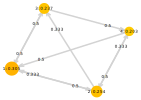

In [6]:
create_weighted_graph(A)

## Truth and Reconciliation
After running PageRank algorithm, we see that the relative importance of the pages is what we expected earlier, with **1** being the most important. However, I have to admit that I was not totally honest about the iterative process that we were running.

In the case of a column-stochastic matrix, like A, simply multiplying the initial vector 

$$
v_{0} = \left(\begin{array}{cc} 
 0.25\\
 0.25\\
 0.25\\
 0.25
\end{array}\right)
$$

by a high power of A yields the same result as performing the **power method**, which is slightly distinct from the process we took. In particular, the true power method contains an additional step that does not make a difference when we deal with column-stochastic matrices, for which the dominant eigenvalue is 1, but it does make a difference in general, when the dominant eigenvalue is not 1. The process is as follows:

**Power Method**:
Begin with a square matrix A with a (unique) dominant eigenvalue. Let $v_{0}$ be an initial guess for an eigenvector of the dominant eigenvalue. Then, for $i \geq 1$:
1. $\bar{v}_{i} = Av_{i-1}$
2. $v_{i} = \frac{\bar{v}_{i}}{||\bar{v}_{i}||}$

The second step is not essential in the case of a column stochastic matrix. However, it is crucial in the case of a matrix with a dominant eigenvalue that is not 1. For example, take the case of the matrix

$$
K = \left(\begin{array}{cc} 
 1 & 0\\
 0 & 2
\end{array}\right)
$$

This is a diagonal matrix that clearly has a dominant eigenvalue of 2, and an associated eigenvector of 
$$
w = \left(\begin{array}{cc} 
 0\\
 1
\end{array}\right)
$$

Then, if we try to perform multiple iterations of the power method without the normalization step, we will see that the vector at each step will indeed be an eigenvector of K. However, it will blow up instead of converging. This makes intuitive sense, as the dominant eigenvalue is 2 -- so, at each step, if we don't normalize, we will simply be multiplying our eigenvector by 2:

In [7]:
K = [
1 0;
0 2
]

# After 5 iterations of the power method without normalization
power_method_iterate(K, [0; 1], 5, false, false)[1]

2-element Vector{Int64}:
  0
 32

In [8]:
# After 10 iterations of the power method without normalization
power_method_iterate(K, [0; 1], 10, false, false)[1]

2-element Vector{Int64}:
    0
 1024

So, clearly, the normalization step is a must. As a result, however, simply going through the power method does not produce a probability vector with elements that sum to 1. Instead, because we normalize using the supremum norm, which assigns as the norm of the vector the absolute value of its greatest component, we will end up with a different eigenvector corresponding to the dominant eigenvalue 1, in which the largest component is clearly 1:

Largest eigenvalue (should be 1): 0.9999997457626641
Page rank weight eigenvector: [1.0, 0.8333335169492287, 0.7777777589453827, 0.6666666101694715]
Pages in order from most to least important: [1, 2, 3, 4]


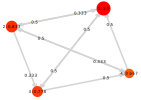

In [9]:
create_weighted_graph(A, false, true, false, true)

To instead get the probability vector that we desire, we can simply divide through by the sum of the components in the eigenvector shown above, as we know that this will normalize the sum of the elements. Then, our result is as desired, and the four pages can be ranked according to the probability that a surfer will end up on a particular page after a substantial amount of link-clicking:

Largest eigenvalue (should be 1): 0.9999997457626641
Page rank weight eigenvector: [0.30508473568378003, 0.25423733575489027, 0.23728812200857485, 0.20338980655275482]
Pages in order from most to least important: [1, 2, 3, 4]


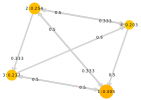

In [10]:
create_weighted_graph(A, false, true, true, true)

## The Rayleigh Quotient
After running our PageRank algorithm, we can use the resulting eigenvector to recover the dominant eigenvalue, and in our case, we can see that it is indeed 1. To do so, we use a formula know as the *Rayleigh quotient*:

**Rayleigh quotient:** For a square matrix A, of which v is an eigenvector corresponding the the eigenvalue $\lambda$, we have the following:

$\lambda = \frac{<Av, v>}{<v, v>}$, where $<,>$ denotes the inner product.

**Proof:**
Given that v is an eigenvector of A corresponding to eigenvalue $\lambda$, we have:

$\frac{<Av, v>}{<v, v>} = \frac{<\lambda v, v>}{<v, v>} = \lambda \frac{<v, v>}{<v, v>} = \lambda$

After running the PageRank algorithm on A, the probability eigenvector that we get is:

$$
v = \left(\begin{array}{cc} 
 0.305\\
 0.254\\
 0.237\\
 0.203
\end{array}\right)
$$

In [11]:
prob_eigenv = power_method_iterate(A, [0.25; 0.25; 0.25; 0.25], 100, true, true)[1]

4-element Vector{Float64}:
 0.30508473568378003
 0.25423733575489027
 0.23728812200857485
 0.20338980655275482

Then, using the Rayleigh quotient, we get a corresponding eigenvalue of 1, as we expected:

In [12]:
rayleigh(A, prob_eigenv)

0.9999997457626641

This value is essentially 1, save for rounding issues. For good measure, we can see that this still holds for the eigenvector that we get when we don't divide through by the end to ensure that the elements sum to 1:

In [13]:
non_stochastic_eigenv = power_method_iterate(A, [0.25; 0.25; 0.25; 0.25], 100, false, true)[1]

4-element Vector{Float64}:
 1.0
 0.8333335169492287
 0.7777777589453827
 0.6666666101694715

In [14]:
rayleigh(A, non_stochastic_eigenv)

0.9999997457626641

## Adding Rigor
While performing the power method for finding the dominant eigenvector, it is important to stay rigorous to the requirements that allow the procedure to converge to the eigenvector, such as the sufficient conditions of the Perron–Frobenius theorem. Otherwise, we can very quickly run into issues where the method fails.

For a particularly extreme example, we can look at the following matrix:

$$
L = \left(\begin{array}{cc} 
 0.5 & 1\\
 0 & -0.5
\end{array}\right)
$$

This aptly named matrix, L, violates the sufficient conditions of the Perron–Frobenius theorem in every way imaginable: it is not positive or even non-negative, and it is not irreducible, as it is upper-triangular. So, if we attempt to perform the power method with it, we immediately run into trouble:

In [15]:
L = [
    0.5 1;
    0 -0.5   
]
power_method_iterate(L, [0.3; 0.7], 1000, true, true)[1]

2-element Vector{Float64}:
 0.30000000000000004
 0.6999999999999998

The only eigenvectors of L are

$
\left(\begin{array}{cc} 
 1\\
 0 
\end{array}\right)
$ and $
\left(\begin{array}{cc} 
 -1\\
 1 
\end{array}\right)
$. So, the fact that our iteration of 1000 steps converges to $
\left(\begin{array}{cc} 
 0.3\\
 0.7 
\end{array}\right)
$ shows a clear failure in the process.

For contrast, when we iterate using the adjacency matrix A from before, we get the same, desired eigenvector every time (at least out of the various initial vectors that I happened to test):

In [16]:
power_method_iterate(A, [16; 2; 3; 4], 1000, true, true)[1]

4-element Vector{Float64}:
 0.30508473568378003
 0.25423733575489027
 0.23728812200857485
 0.20338980655275482

In [17]:
power_method_iterate(A, [100; 101; 102; 103], 1000, true, true)[1]

4-element Vector{Float64}:
 0.30508473568378003
 0.25423733575489027
 0.23728812200857485
 0.20338980655275482

Regardless, we are still playing with fire somewhat with how we designed our adjacency matrix A. While this one in particular may be diagonalizable and irreducible, and thus basically guaranteed to converge to a dominant eigenvector, it is possible that another column-stochastic matrix of the same form may not converge properly, as it may not fulfill one or more of the diagnolizability or irreducibility requirements.

To work around this issue, there are several steps that we could take to reduce the possibility that the power method fails to converge on our matrix.

## Positive Matrices
To more precisely fulfill the conditions of the Perron–Frobenius theorem, we can deal exclusively with matrices for which every entry is strictly positive. If we are thinking of matrices as representing the set of probabilities that an internet surfer will travel to page **i** while exploring page **j**, having a matrix of exclusively positive values means that there is a nonzero probability that the next page that the surfer will visit is the one that they are currently on. 

Intuitively, this makes sense, as some web pages might feature a link that leads to themselves, such as a homepage logo that leads to itself. Let's define the following adjacency matrix as an example:

$$
B = \left(\begin{array}{cc} 
 0.2 & 0.5 & 0.25 & 0.3\\
 0.6 & 0.1 & 0.25 & 0.1\\
 0.1 & 0.2 & 0.25 & 0.1\\
 0.1 & 0.2 & 0.25 & 0.5
\end{array}\right)
$$

So, from page **1**, there is a 20% chance on returning back to **1**, 60% chance of traveling to **2**, and a 10% chance of traveling to either **3** and **4**, and so forth. This is certainly something that you can imagine happening in real life: for instance, if page **1** has links to pages **3** and **4**, a link to **2** that is six times the size of those links, and a home button that is roughly twice the size of the standard links.

Then, we see similar convergence to before:

In [18]:
B = [
 0.2 0.5 0.25 0.3;
 0.6 0.1 0.25 0.1;
 0.1 0.2 0.25 0.1;
 0.1 0.2 0.25 0.5
]

4×4 Matrix{Float64}:
 0.2  0.5  0.25  0.3
 0.6  0.1  0.25  0.1
 0.1  0.2  0.25  0.1
 0.1  0.2  0.25  0.5

In [19]:
power_method_iterate(B, [0.25; 0.25; 0.25; 0.25], 100, true, true)[1]

4-element Vector{Float64}:
 0.3169856459330143
 0.2811004784688995
 0.15071770334928228
 0.2511961722488038

Largest eigenvalue (should be 1): 1.0
Page rank weight eigenvector: [0.3169856459330143, 0.2811004784688995, 0.15071770334928228, 0.2511961722488038]
Pages in order from most to least important: [1, 2, 4, 3]


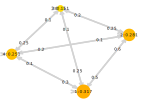

In [20]:
create_weighted_graph(B, false, true, true, true)

## Damping Factor
Now, imagine that we have are back to the same setup as with the adjacency matrix A from before. However, now suppose that the surfer who is navigating between the four web pages is prone to being distracted, and may, at any given moment type the name of one of the pages at random into the search bar and navigate there instead.

Let's say that the chance of this happening is extremely small -- in this scenario, the chance of typing the name of one of the web pages and traveling there is 5% for each page. However, as unlikely as this is, we have to take this into account. In total, we have a scenario in which there is now a 20% chance that the surfer will navigate through the search bar, and 80% that it will still be through the links on the page. In other works, the likelihood of clicking on any particular link has been "damped" by a factor of 5% (0.05). So, we must update our matrix to reflect this, through the following formula:

$\bar{A} = (1-\alpha)A + \alpha J$, where $\alpha$ is the damping factor (the probability of traveling to a particular page via the search bar), and $J$ is a matrix for which each entry is $\frac{1}{n}$, with n being a side length of both of the matrices.

Notice that any matrix of this form is clearly positive. Moreover, this augmented matrix is essentially comprised of a weighted sum of two matrices whose columns sum to 1, for which the weights $(1-\alpha)$ and $\alpha$, which also sum to 1. So, the augmented matrix $\bar{A}$ remains column-stochastic.

The augmented matrix in our case, which we will call C, appears as follows:
$$
C = (0.95)\left(\begin{array}{cc} 
 0.0 & 0.333333 & 0.5 & 0.5\\
 0.5 & 0.0      & 0.0 & 0.5\\
 0.5 & 0.333333 & 0.0 & 0.0\\
 0.0 & 0.333333 & 0.5 & 0.0
\end{array}\right) + (0.05)\left(\begin{array}{cc} 
 \frac{1}{n} & \frac{1}{n} & \frac{1}{n} & \frac{1}{n}\\
 \frac{1}{n} & \frac{1}{n} & \frac{1}{n} & \frac{1}{n}\\
 \frac{1}{n} & \frac{1}{n} & \frac{1}{n} & \frac{1}{n}\\
 \frac{1}{n} & \frac{1}{n} & \frac{1}{n} & \frac{1}{n}
\end{array}\right) = \left(\begin{array}{cc} 
 0.0125 & 0.329167 &  0.4875 & 0.4875 \\
 0.4875 & 0.012500  & 0.0125 & 0.4875 \\
 0.4875 & 0.329167  & 0.0125 & 0.0125 \\
 0.0125 & 0.329167  & 0.4875 & 0.0125 
\end{array}\right)
$$

In [21]:
C = search_bar(A, 0.05)

4×4 Matrix{Float64}:
 0.0125  0.329167   0.4875  0.4875
 0.4875  0.0125002  0.0125  0.4875
 0.4875  0.329167   0.0125  0.0125
 0.0125  0.329167   0.4875  0.0125

Then, if we performm the PageRank algorithm on this augmented matrix C, we should again "C" the desired convergence. For the sake of improving the readability of the image, we will avoid displaying labels for the self-edges, which have the lowest weights on the graph:

Largest eigenvalue (should be 1): 0.9999999999999998
Page rank weight eigenvector: [0.3032236466679638, 0.2541795855297024, 0.23702141412913802, 0.2055753536731958]
Pages in order from most to least important: [1, 2, 3, 4]


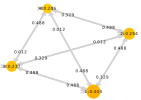

In [22]:
create_weighted_graph(C, false, true, true, true)

As expected, the relative "importance" ratings, as given by the long-term probabilities of the surfer landing on each web page, are very close to what we got in the earlier example with A, and the dominant eigenvalue is once again confirmed to be 1.

## Sandbox!!
Before I continue on to address various problematic types of matrices for the PageRank algorithm and how we deal with them, I will provide an opportunity for the reader to play around with creating and visualizing various adjacency matrices and their corresponding networks, along with relative "importance" ratings as generated by the PageRank algorithm:

In [23]:
# create_random_adjacency_matrix(replacement::Bool=true, self_edges::Bool=false, 
#         random_weights::Bool=false, chaos_column_weight::Real=1., side=nothing)

# This will generate a random adjacency matrix where each "link" coming from a "web page" is required
# to have the same weight

# Matrices will be between 3x3 and 6x6 in side
# If you want to allow self_edges, set the second argument to true
# If you want a larger matrix, enter an integer for the fifth argument

D = create_random_adjacency_matrix(false, false, false, 1., nothing)
# Uncomment the following line if you would like to augment the matrix by introducing a damping factor
# D = search_bar(D, 0.05)

6×6 Matrix{Float64}:
 0.0  0.0  0.2  0.0   0.0  0.333333
 0.0  0.0  0.2  0.25  0.0  0.0
 0.0  0.0  0.0  0.25  1.0  0.0
 1.0  0.5  0.2  0.0   0.0  0.333333
 0.0  0.0  0.2  0.25  0.0  0.333333
 0.0  0.5  0.2  0.25  0.0  0.0

Largest eigenvalue (should be 1): 1.0
Page rank weight eigenvector: [0.09821428571428573, 0.10714285714285715, 0.22321428571428573, 0.25, 0.16071428571428573, 0.16071428571428573]
Pages in order from most to least important: [4, 3, 5, 6, 2, 1]


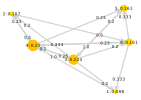

In [26]:
# Graphing the matrix
# If you want curved edges, set the second argument to true
create_weighted_graph(D, false, true, true, true)

In [32]:
# This will generate a random adjacency matrix where "links" coming from a "web page" 
# may have different weights, but the weights are integer multiples of each other

E = create_random_adjacency_matrix(true, false, false, 1., nothing)
# Uncomment the following line if you would like to augment the matrix by introducing a damping factor
# E = search_bar(E, 0.05)

5×5 Matrix{Float64}:
 0.0  0.0  0.0  1.0  0.25
 1.0  0.0  0.5  0.0  0.0
 0.0  0.5  0.0  0.0  0.5
 0.0  0.0  0.0  0.0  0.25
 0.0  0.5  0.5  0.0  0.0

Largest eigenvalue (should be 1): 1.0
Page rank weight eigenvector: [0.13333333333333333, 0.26666666666666666, 0.26666666666666666, 0.06666666666666667, 0.26666666666666666]
Pages in order from most to least important: [2, 3, 5, 1, 4]


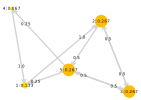

In [33]:
# Graphing the matrix
create_weighted_graph(E, false, true, true, true)

In [34]:
# This will generate a random adjacency matrix where "links" coming from a "web page" 
# have randomly generated weights, through "chopping up" a continuous uniform distribution

F = create_random_adjacency_matrix(false, false, true, 1., nothing)
# Uncomment the following line if you would like to augment the matrix by introducing a damping factor
# F = search_bar(F, 0.05)

6×6 Matrix{Float64}:
 0.0        0.0       0.126306  0.247377  0.0       0.0
 0.0116775  0.0       0.594121  0.293093  0.0       1.0
 0.0740186  0.0       0.0       0.06149   0.309793  0.0
 0.0155174  0.821762  0.0       0.0       0.419645  0.0
 0.68929    0.178238  0.279573  0.0       0.0       0.0
 0.209497   0.0       0.0       0.39804   0.270562  0.0

Largest eigenvalue (should be 1): 0.9999999999999999
Page rank weight eigenvector: [0.07886320429205863, 0.28573366942984, 0.06145072897935934, 0.28742196460384045, 0.1224682699087092, 0.16406216278619243]
Pages in order from most to least important: [4, 2, 6, 5, 1, 3]


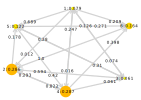

In [35]:
# Graphing the matrix
create_weighted_graph(F, false, true, true, true)

In [36]:
# Really big network!!
G = create_random_adjacency_matrix(false, false, false, 1., 10)
# Uncomment the following line if you would like to augment the matrix by introducing a damping factor
# G = search_bar(G, 0.05)

10×10 Matrix{Float64}:
 0.0  0.2  0.0  0.125  0.2  0.111111  0.142857  0.142857  0.111111  0.142857
 0.0  0.0  0.0  0.125  0.2  0.111111  0.0       0.0       0.111111  0.0
 0.0  0.0  0.0  0.125  0.2  0.111111  0.142857  0.142857  0.111111  0.142857
 0.0  0.0  0.0  0.0    0.2  0.111111  0.0       0.142857  0.111111  0.142857
 0.0  0.0  0.0  0.125  0.0  0.111111  0.142857  0.142857  0.111111  0.142857
 1.0  0.2  0.5  0.125  0.0  0.0       0.142857  0.142857  0.111111  0.0
 0.0  0.2  0.0  0.125  0.0  0.111111  0.0       0.0       0.111111  0.142857
 0.0  0.2  0.0  0.0    0.0  0.111111  0.142857  0.0       0.111111  0.142857
 0.0  0.2  0.5  0.125  0.0  0.111111  0.142857  0.142857  0.0       0.142857
 0.0  0.0  0.0  0.125  0.2  0.111111  0.142857  0.142857  0.111111  0.0

Largest eigenvalue (should be 1): 1.0
Page rank weight eigenvector: [0.10941847644214295, 0.0637626708726253, 0.09666594226761788, 0.07672052551373446, 0.08055495188968156, 0.21507812177103566, 0.07248745745266628, 0.0732527428281161, 0.127476411478214, 0.08458269948416564]
Pages in order from most to least important: [6, 9, 1, 3, 10, 5, 4, 8, 7, 2]


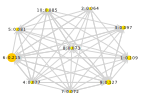

In [37]:
# Graphing the matrix
create_weighted_graph(G, false, true, true, true, true)

## Problematic Network 1: Disconnected Components
The first problem that we may encounter in one of our networks of web pages is a situation in which the network of web pages consists of two or more entirely disconnected components. So, suppose that we have five web pages, such that:
- Page **1** has links to **2** and **3**
- Page **2** has links to **1** and **3**
- Page **3** has links to **1** and **2**
- Pages **4** and **5** only have links to each other

For simplicity, let us think of this in the scenario where there are no self-links, and each link is of equal prominence, meaning that the surfer has an equal chance of clicking on any of the links on the page that they are currently on. So, it is obviously the case that, if the surfer is in one of the components, they have no chance of maneuvering to the other component.

The adjacency matrix here appears as follows:

$$
H = \left(\begin{array}{cc} 
 0 & 0.5 & 0.5 & 0 & 0\\
 0.5 & 0 & 0.5 & 0 & 0\\
 0.5 & 0.5 & 0 & 0 & 0\\
 0 & 0 & 0 & 0 & 1 \\
 0 & 0 & 0 & 1 & 0 
\end{array}\right)
$$

*Note:* the idea for this example comes from [this resource](http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html).

This is a problem, as there are two different eigenvectors, linearly independent eigenvectors that correspond to the eigenvalue 1 in this matrix:

$$
v = \left(\begin{array}{cc} 
 1\\
 1\\
 1\\
 0 \\
 0 
\end{array}\right)
$$

as we have that

$$
Hv = \left(\begin{array}{cc} 
 0 + 0.5 + 0.5\\
 0.5 + 0 + 0.5\\
 0.5 + 0.5 + 0\\
 0 \\
 0 
\end{array}\right)  = \left(\begin{array}{cc} 
 1\\
 1\\
 1\\
 0 \\
 0 
\end{array}\right) = v
$$

and 

$$
w = \left(\begin{array}{cc} 
 0\\
 0\\
 0\\
 1 \\
 1 
\end{array}\right) 
$$

as we have that

$$
Hw = \left(\begin{array}{cc} 
 0\\
 0\\
 0\\
 0 + 1 \\
 1 + 0 
\end{array}\right)  = \left(\begin{array}{cc} 
 0\\
 0\\
 0\\
 1 \\
 1 
\end{array}\right) = w
$$

This is a problem, as we will no longer have just one eigenvector that the power method process can converge to, meaning that our PageRank algorithm might yield a different result depending on our initial guess. For example:

In [38]:
H = [
 0 0.5 0.5 0 0;
 0.5 0 0.5 0 0;
 0.5 0.5 0 0 0;
 0 0 0 0 1;
 0 0 0 1 0 
]

5×5 Matrix{Float64}:
 0.0  0.5  0.5  0.0  0.0
 0.5  0.0  0.5  0.0  0.0
 0.5  0.5  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0  0.0

In [39]:
power_method_iterate(H, [0.3; 0.3; 0.4; 0; 0], 100, true, true)[1]

5-element Vector{Float64}:
 0.3333333333333333
 0.3333333333333333
 0.3333333333333333
 0.0
 0.0

In [40]:
power_method_iterate(H, [0; 0; 0; 0.5; 0.5], 100, true, true)[1]

5-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.5
 0.5

This seems like a big problem, but, luckily, the solution here is something that we have already seen. Earlier, we discussed the idea of a surfer who becomes distracted, and then uses a search bar to jump to a different page at random, even if that page does not have a link leading to it. Now, we can leverage that same idea: instead of allowing the surfer to stay trapped within one of the two components, they would have the opportunity to, at random, "teleport" from one component to the next.

So, in short, to get around this problem, we can again invoke the damping factor:

$$
\bar{H} = (1-\alpha)H + \alpha J = \left(\begin{array}{cc} 
 0.01  & 0.485 & 0.485 & 0.01 & 0.01\\
 0.485 & 0.01  & 0.485 & 0.01 & 0.01\\
 0.485 & 0.485 & 0.01  & 0.01 & 0.01\\
 0.01  & 0.01  & 0.01  & 0.01 & 0.96\\
 0.01  & 0.01  & 0.01  & 0.96 & 0.01
\end{array}\right)
$$

where $\alpha = 0.05$ and J is a matrix for which $J_{ij} = 0.2$ $\forall i, j$.

In [41]:
H_bar = search_bar(H, 0.05)

5×5 Matrix{Float64}:
 0.01   0.485  0.485  0.01  0.01
 0.485  0.01   0.485  0.01  0.01
 0.485  0.485  0.01   0.01  0.01
 0.01   0.01   0.01   0.01  0.96
 0.01   0.01   0.01   0.96  0.01

Now, we should see convergence to a unique eigenvector:

In [42]:
power_method_iterate(H_bar, [0.3; 0.3; 0.4; 0; 0], 100000, true, true)[1]

5-element Vector{Float64}:
 0.2000000000000001
 0.2000000000000001
 0.2000000000000001
 0.19999999999999984
 0.19999999999999984

In [43]:
power_method_iterate(H_bar, [0; 0; 0; 0.5; 0.5], 100000, true, true)[1]

5-element Vector{Float64}:
 0.19999999999999993
 0.19999999999999993
 0.19999999999999993
 0.2000000000000001
 0.20000000000000007

Intuitively, the convergence here makes sense: by construction, this matrix is also row-stochastic, so, as we saw previously,

$$\left(\begin{array}{cc} 
 1\\
 1\\
 1\\
 1 \\
 1 
\end{array}\right)$$

should be an eigenvector, and, thus, so should

$$\left(\begin{array}{cc} 
 0.2\\
 0.2\\
 0.2\\
 0.2\\
 0.2
\end{array}\right)$$

## Problematic Network 2: A pages with no outgoing links
Now, here is a more subtle issue. Suppose, now, that instead of having links leading to **1** and **4**, page **3** would have no outgoing links whatsoever. The adjacency matrix here appears as follows

$$
J = \left(\begin{array}{cc} 
 0 & 0.333333 & 0 & 0.5\\
 0.5 & 0      & 0 & 0.5\\
 0.5 & 0.333333 & 0 & 0\\
 0 & 0.333333 & 0 & 0
\end{array}\right)
$$

It should make intuitive sense why this is a problem, as, if the surfer ever ends up on page **3**, they would be stuck. Moreover, using a damping factor fails to solve this problem, as the damping factor causes a column of all zeroes to be added to a column of entries that add up to 1 that has been scaled down by a factor less than 1, meaning that the augmented matrix is still not column-stochastic:

$$
K = (0.95)\left(\begin{array}{cc} 
 0 & 0.333333 & 0 & 0.5\\
 0.5 & 0      & 0 & 0.5\\
 0.5 & 0.333333 & 0 & 0\\
 0 & 0.333333 & 0 & 0
\end{array}\right) + (0.05)\left(\begin{array}{cc} 
 1 & 1 & 1 & 1\\
 1 & 1 & 1 & 1\\
 1 & 1 & 1 & 1\\
 1 & 1 & 1 & 1
\end{array}\right) = 
\left(\begin{array}{cc} 
 0.0125 & 0.329166 & 0.0125 & 0.4875\\
 0.4875 & 0.0125   & 0.0125 & 0.4875\\
 0.4875 & 0.329166 & 0.0125 & 0.0125\\
 0.0125 & 0.329166 & 0.0125 & 0.0125
\end{array}\right)
$$

In [44]:
J = [
 0 0.333333 0 0.5;
 0.5 0      0 0.5;
 0.5 0.333333 0 0;
 0 0.333333 0 0
]

4×4 Matrix{Float64}:
 0.0  0.333333  0.0  0.5
 0.5  0.0       0.0  0.5
 0.5  0.333333  0.0  0.0
 0.0  0.333333  0.0  0.0

In [45]:
K = search_bar(J, 0.05, false)

4×4 Matrix{Float64}:
 0.0125  0.329166  0.0125  0.4875
 0.4875  0.0125    0.0125  0.4875
 0.4875  0.329166  0.0125  0.0125
 0.0125  0.329166  0.0125  0.0125

Largest eigenvalue (should be 1): 0.6757595060884272
Page rank weight eigenvector: [0.24663592502141174, 0.2873716053158619, 0.3242402065399676, 0.14175226312275874]
Pages in order from most to least important: [3, 2, 1, 4]


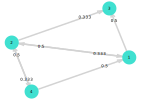

In [46]:
create_weighted_graph(J, false, false)

Indeed, for certain initial values, the power method simply does not converge:

In [47]:
power_method_iterate(J, [0; 0; 1; 0], 1000, true, true)[1]

4-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN

For contrast, the power method on A for the same initial value converges to the expected eigenvector:

In [48]:
power_method_iterate(A, [0; 0; 1; 0], 1000, true, true)[1]

4-element Vector{Float64}:
 0.3050847356837801
 0.2542373357548903
 0.23728812200857483
 0.2033898065527548

The fix here is essentially the same as using the damping factor, but now we isolate it to the problematic columns(s). Specifically, we suppose that, if the surfer gets trapped on web page **3**, then they should be able to randomly "teleport" to one of the pages by using the search bar. We can accomplish this by filling the problematic column with values of $\frac{1}{n}$, where n is the length of each side of the matrix:

$
\left(\begin{array}{cc} 
 0 & 0.333333 & 0 & 0.5\\
 0.5 & 0      & 0 & 0.5\\
 0.5 & 0.333333 & 0 & 0\\
 0 & 0.333333 & 0 & 0
\end{array}\right)$ &rarr; $\left(\begin{array}{cc} 
 0 & 0.333333 & 0.25 & 0.5\\
 0.5 & 0      & 0.25 & 0.5\\
 0.5 & 0.333333 & 0.25 & 0\\
 0 & 0.333333 & 0.25 & 0
\end{array}\right)
$

In [49]:
M = fill_columns(J)

4×4 Matrix{Float64}:
 0.0  0.333333  0.25  0.5
 0.5  2.5e-7    0.25  0.5
 0.5  0.333333  0.25  0.0
 0.0  0.333333  0.25  0.0

Then, the PageRank algorithm on this new adjacency matrix should converge as expected:

Largest eigenvalue (should be 1): 1.0
Page rank weight eigenvector: [0.2526315609972267, 0.28421057717452436, 0.2947368211634312, 0.1684210406648178]
Pages in order from most to least important: [3, 2, 1, 4]


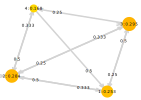

In [50]:
create_weighted_graph(M, false, true, true, true)

We could also run into a similar scenario, in which the probabilities of outgoing edges from a node end up less than 1 but greater than 0, leading to an adjacency matrix that is not quite column-stochastic. It is more difficult to come up with a real-life explanation for how this could happen -- perhaps this would be if there are links to some of the pages, but they are disabled for part of the day.

In this case, the fix is very similar: instead of filling the problematic column with equal values, we add $\frac{1-\sum_{i} A_{ij}}{n}$, where n is the number of entries in each row and column of the matrix:

$
\left(\begin{array}{cc} 
 0 & 0.333333 & 0 & 0.5\\
 0.5 & 0      & 0.3 & 0.5\\
 0.5 & 0.333333 & 0.3 & 0\\
 0 & 0.333333 & 0 & 0
\end{array}\right)$ &rarr; $\left(\begin{array}{cc} 
 0 & 0.333333 & 0.1 & 0.5\\
 0.5 & 0      & 0.4 & 0.5\\
 0.5 & 0.333333 & 0.4 & 0\\
 0 & 0.333333 & 0.1 & 0
\end{array}\right)
$

In [51]:
N = [
 0 0.333333 0 0.5;
 0.5 0      0.3 0.5;
 0.5 0.333333 0.3 0;
 0 0.333333 0 0
]

4×4 Matrix{Float64}:
 0.0  0.333333  0.0  0.5
 0.5  0.0       0.3  0.5
 0.5  0.333333  0.3  0.0
 0.0  0.333333  0.0  0.0

In [52]:
P = fill_columns(N)

4×4 Matrix{Float64}:
 0.0  0.333333  0.1  0.5
 0.5  2.5e-7    0.4  0.5
 0.5  0.333333  0.4  0.0
 0.0  0.333333  0.1  0.0

## Sandbox 2!!
I will leave several more functions here that the reader would be able to play with. These, however, autogenerate and display the aforementioned problematic networks:

In [53]:
# create_random_adjacency_matrix(replacement::Bool=true, self_edges::Bool=false, 
#         random_weights::Bool=false, chaos_column_weight::Real=1., side=nothing)

# This will generate a random adjacency matrix where each "link" coming from a "web page"
# has randomly generated weights.
# Additionally, one of the columns will be the "chaos column," which prevents the matrix
# from being column-stochastic.
# Here, the fourth argument controls the sum of the entries of the "chaos column."
# The default is 0 (all zeroes), but you can choose to change that by providing another value.

# Matrices will be between 3x3 and 6x6 in side
# If you want to allow self_edges, set the second argument to true
# If you want a larger matrix, enter an integer for the fifth argument

Q = create_random_adjacency_matrix(false, false, true, 0, nothing)
# Uncomment the following line if you would like to augment the matrix by introducing a damping factor
# Q = search_bar(Q, 0.05)

5×5 Matrix{Float64}:
 0.0       0.0611292  0.0  0.000476888  0.24194
 0.328892  0.0        0.0  0.686113     0.0
 0.0       0.670712   0.0  0.312848     0.68037
 0.520158  0.0        0.0  0.0          0.0776903
 0.15095   0.268159   0.0  0.000562015  0.0

In [54]:
R = fill_columns(Q)

5×5 Matrix{Float64}:
 0.0       0.0611292  0.2  0.000476888  0.24194
 0.328892  0.0        0.2  0.686113     0.0
 0.0       0.670712   0.2  0.312848     0.68037
 0.520158  0.0        0.2  0.0          0.0776903
 0.15095   0.268159   0.2  0.000562015  0.0

Largest eigenvalue (should be 1): 1.0000000000000002
Page rank weight eigenvector: [0.12234971834621933, 0.2149972082378616, 0.3651516639248276, 0.14826566839054564, 0.14923574110054577]
Pages in order from most to least important: [3, 2, 5, 4, 1]


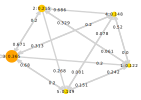

In [55]:
# Graphing the matrix
create_weighted_graph(R, false, true, true, true)

In [56]:
# function create_segmented_adjacency_matrix(n::Int, chaos_weights::Array{<:Real,1}=[-1], replacement::Bool=true, self_edges::Bool=false, 
#         random_weights::Bool=false)

# This will generate a random adjacency matrix with disconnected components
# The first argument specifies how many components, each of which is randomly generated as either 2x2, 3x3, or 4x4
S = create_segmented_adjacency_matrix(2, [-1], true, false, false)

6×6 Matrix{Float64}:
 0.0  0.5  0.5  0.666667  0.0  0.0
 0.0  0.0  0.0  0.0       0.0  0.0
 0.5  0.0  0.0  0.333333  0.0  0.0
 0.5  0.5  0.5  0.0       0.0  0.0
 0.0  0.0  0.0  0.0       0.0  1.0
 0.0  0.0  0.0  0.0       1.0  0.0

In [57]:
# Use a damping factor to bring the matrix together
T = search_bar(S, 0.05)

6×6 Matrix{Float64}:
 0.00833333  0.483333    0.483333    0.641667    0.00833333  0.00833333
 0.00833333  0.00833333  0.00833333  0.00833333  0.00833333  0.00833333
 0.483333    0.00833333  0.00833333  0.325       0.00833333  0.00833333
 0.483333    0.483333    0.483333    0.00833333  0.00833333  0.00833333
 0.00833333  0.00833333  0.00833333  0.00833333  0.00833333  0.958333
 0.00833333  0.00833333  0.00833333  0.00833333  0.958333    0.00833333

Largest eigenvalue (should be 1): 0.9999999999999999
Page rank weight eigenvector: [0.24691358024691354, 0.0, 0.1975308641975308, 0.22222222222222215, 0.1666666666666668, 0.1666666666666668]
Pages in order from most to least important: [1, 4, 3, 5, 6, 2]


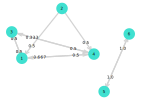

In [58]:
# Graphing the matrix
create_weighted_graph(S, false, false, true, true)

Largest eigenvalue (should be 1): 0.9999999999999999
Page rank weight eigenvector: [0.243991190270995, 0.008333333333333333, 0.19400316001149104, 0.22033898305084756, 0.16666666666666646, 0.1666666666666665]
Pages in order from most to least important: [1, 4, 3, 6, 5, 2]


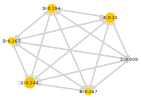

In [59]:
# Graphing the damping factor matrix, with weights according to importance
create_weighted_graph(T, false, true, true, true, true)

In [86]:
# This will generate a random adjacency matrix with disconnected components
# The first argument specifies how many components, each of which is randomly generated as either 2x2, 3x3, or 4x4

# However, in this case, we are adding the twist that one of the components will have a column of zeroes
# So, one of the components will have a web page with no outgoing links
# To create your own, replace the second argument's default, [-1], with a list containing what you want the sum of
# the entries to be in the "chaos" column of each component. If you want the component to remain column-stochastic,
# put 1 in that spot:
U = create_segmented_adjacency_matrix(2, [1, 0], true, false, false)

8×8 Matrix{Float64}:
 0.0  0.0  0.333333  0.333333  0.0       0.0  0.0  0.0
 0.5  0.0  0.666667  0.333333  0.0       0.0  0.0  0.0
 0.0  0.0  0.0       0.333333  0.0       0.0  0.0  0.0
 0.5  1.0  0.0       0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0       0.0       0.0       0.0  0.5  0.0
 0.0  0.0  0.0       0.0       0.666667  0.0  0.0  0.0
 0.0  0.0  0.0       0.0       0.0       0.0  0.0  1.0
 0.0  0.0  0.0       0.0       0.333333  0.0  0.5  0.0

Largest eigenvalue (should be 1): 1.0
Page rank weight eigenvector: [0.1739130409453864, 0.30434782165442625, 0.1304347807090398, 0.39130434212711945, 2.991597622950923e-9, 2.384948185136279e-9, 5.003410636436513e-9, 4.184071715519062e-9]
Pages in order from most to least important: [4, 2, 1, 3, 7, 8, 5, 6]


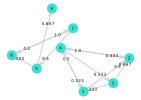

In [87]:
# Graphing the matrix
create_weighted_graph(U, false, false, true, true)

In [88]:
# To fix: fill the problematic column
V = fill_columns(U)
# Alternatively, you could also use a damping factor:
# V = search_bar(V, 0.05)

8×8 Matrix{Float64}:
 0.0  0.0  0.333333  0.333333  0.0       0.125  0.0  0.0
 0.5  0.0  0.666667  0.333333  0.0       0.125  0.0  0.0
 0.0  0.0  0.0       0.333333  0.0       0.125  0.0  0.0
 0.5  1.0  0.0       0.0       0.0       0.125  0.0  0.0
 0.0  0.0  0.0       0.0       0.0       0.125  0.5  0.0
 0.0  0.0  0.0       0.0       0.666667  0.125  0.0  0.0
 0.0  0.0  0.0       0.0       0.0       0.125  0.0  1.0
 0.0  0.0  0.0       0.0       0.333333  0.125  0.5  0.0

Largest eigenvalue (should be 1): 1.0000042576439256
Page rank weight eigenvector: [0.17390496368214844, 0.3043331555094338, 0.13042886507282614, 0.3912849923892664, 9.952993118724287e-6, 8.428539258790862e-6, 1.6052009528901354e-5, 1.3589804418749061e-5]
Pages in order from most to least important: [4, 2, 1, 3, 7, 8, 5, 6]


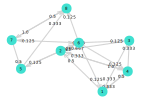

In [90]:
# Graphing the matrix
create_weighted_graph(V, false, false, true, true)

Largest eigenvalue (should be 1): 1.0000042576439256
Page rank weight eigenvector: [0.17390496368214844, 0.3043331555094338, 0.13042886507282614, 0.3912849923892664, 9.952993118724287e-6, 8.428539258790862e-6, 1.6052009528901354e-5, 1.3589804418749061e-5]
Pages in order from most to least important: [4, 2, 1, 3, 7, 8, 5, 6]


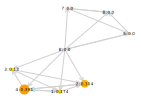

In [91]:
# Graphing the matrix, with weights according to importance
create_weighted_graph(V, false, true, true, true, true)

## More Generally: Eigenvector Centrality
The Google PageRank algorithm is closely related to [**eigenvector centrality**](https://en.wikipedia.org/wiki/Eigenvector_centrality), a method used to measure the *centrality*, or relative influence, of a particular node in a graph. Eigenvector centrality uses a somewhat simpler approach, with a binary adjacency matrix, in which $a_{ij} = 1$ if there exists an edge between nodes i and j, and $a_{ij} = 0$ otherwise. So, the adjacency matrix appears as follows:

$$A = \left(\begin{array}{cc} 
 a_{11} & a_{12} & ... & a_{1n}\\
 a_{21} & a_{22} & ... & a_{2n}\\
 ...    & ... & ... & ...\\
 a_{n1} & a_{n2} & ... & a_{nn}
\end{array}\right)
$$

and the vector of centrality values corresponding to each nodes can be represented as the following:

$$x = \left(\begin{array}{cc} 
 x_{1} \\
 x_{2} \\
 ...  \\
 x_{n} 
\end{array}\right)
$$

We define the centrality of a node v to be dependent on the number of nodes that it shares an edges with, but with a catch! Adjacent nodes with greater centrality are weighed more heavily, making the relationship interconnected. So, we define the centrality score of a given vertex v as:

$$
x_{v} = \frac{1}{\lambda} \sum_{t \in G} a_{vt}x_{t}
$$

where $\lambda$ is a constant and G is the graph containing all of the nodes in question.

Then, if we rewrite the formula more explicitly in terms of the set of nodes, we get:

$$
x_{v} = \frac{1}{\lambda} \sum_{t = 1}^{n} a_{vt}x_{t}
$$

Here, we may start to notice that the formula for the centrality of node v resembles one step in a matrix multiplication process. Building off of this, we see that the centrality formula for all nodes at once can be represented as follows:

$$
\left(\begin{array}{cc} 
 x_{1} \\
 x_{2} \\
 ...  \\
 x_{n} 
\end{array}\right) = \frac{1}{\lambda}\left(\begin{array}{cc} 
 a_{11} & a_{12} & ... & a_{1n}\\
 a_{21} & a_{22} & ... & a_{2n}\\
 ...    & ... & ... & ...\\
 a_{n1} & a_{n2} & ... & a_{nn}
\end{array}\right)\left(\begin{array}{cc} 
 x_{1} \\
 x_{2} \\
 ...  \\
 x_{n} 
\end{array}\right)
$$

which can be written more concisely as 

$$x = \frac{1}{\lambda}Ax$$

which, in turn, can be rearranged to

$$Ax = \lambda x$$.

Thus, the method for finding the centrality of nodes can be found through an eigenvalue-eigenvector equation, where the centrality vector x is the eigenvector, the constant $\lambda$ is the eigenvalue, and A is the adjacency matrix. This is very similar to what we saw in the PageRank algorithm, with A serving as a weighted adjacency matrix and v being a vector representing the probabilities that a surfer travels to a given node that serves as the "centrality" or "importance" vector. The PageRank equation also uses an eigenvalue-eigenvector relationship, albeit with $\lambda = 1$, as the matrix is column-stochastic.

## Thank you for reading!